## How formation plays a part in overall points achieved

In Fantasy Premier League (FPL) we have a squad that consists of 15 players: 2 Goalkeepers (GK), 5 Defenders (DEF), 5 Midfielders (MID) and 3 Forwards (FWD). From these 15, we must choose a starting 11 each week in our chosen formation. The only requirements of each formation are that you have 1 GK, at least 3 DEF and at least one FWD. The other 4 players are benched. 

In this Notebook we will look at optimising the formation we choose each week by analysing player performances in each position. Analysis will be performed on different outfield positions to see which formation would maximize points. Average points, expected points and position will all be considered, as well as types of players in each position e.g., “attacking” defenders.

In [12]:
import os
import math
import itertools
import re
import random
from collections import OrderedDict
from pathlib import Path
import multiprocessing as mp
from datetime import datetime
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger
from scipy.stats import linregress
from scipy import stats
rng = np.random.default_rng()
%matplotlib inline

We begin by accessing our data on game weeks, teams and fixtures. We do this by reading these pickle file into three data frames which we will utilise in our analysis. 

In [13]:
os.chdir('../data') 
gws_data = 'clean/20_21/gws20_21.pkl'
teams_data = 'clean/20_21/teams20_21.pkl'
fixtures_data = 'clean/20_21/fixtures20_21.pkl'
gws = pd.read_pickle(gws_data)
teams = pd.read_pickle(teams_data)
fixtures = pd.read_pickle(fixtures_data)

Let's have a look at the columns and rows in each of our data frames

In [14]:
gws

,id,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
gw,,,,,,,,,,,,,,,,,,,,,
1,3,David Luiz Moreira Marinho,DEF,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,55.0,False,0.0,1
1,4,Pierre-Emerick Aubameyang,MID,Arsenal,5.0,0.0,0.0,19.0,1.0,15.3,...,0.0,54.0,7.0,0.0,0.0,0.0,120.0,False,1.0,1
1,5,Cédric Soares,DEF,Arsenal,3.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,False,0.0,1
1,6,Alexandre Lacazette,FWD,Arsenal,4.0,0.0,1.0,29.0,0.0,12.7,...,0.0,48.0,7.0,0.0,0.0,0.0,85.0,False,0.0,1
1,7,Shkodran Mustafi,DEF,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,False,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,563,Rayan Ait Nouri,DEF,Wolves,-0.5,0.0,0.0,5.0,0.0,1.9,...,1.0,19.0,0.0,-501.0,270.0,771.0,50.0,True,1.0,38
38,581,Owen Otasowie,MID,Wolves,-0.1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-13.0,12.0,25.0,45.0,True,0.0,38
38,610,Theo Corbeanu,MID,Wolves,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,129.0,190.0,61.0,44.0,True,0.0,38


We analyse the game week data frame in further detail to figure out all the rows inside.

In [15]:
gws.columns

Index(['id', 'name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw'],
      dtype='object')

Next let's look at our teams data frame which provides information on each of the 20 premier league squads in the 2020/21 season

In [16]:
teams

,code,id,name,short_name,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
id,,,,,,,,,,,,
1,3,1,Arsenal,ARS,4,1200,1250,1130,1150,1220,1210,1
2,7,2,Aston Villa,AVL,3,1100,1160,1120,1140,1080,1100,2
3,36,3,Brighton,BHA,3,1130,1130,1150,1190,1100,1130,131
4,90,4,Burnley,BUR,2,1060,1070,1040,1090,1040,1080,43
5,8,5,Chelsea,CHE,4,1250,1280,1260,1300,1250,1310,4
6,31,6,Crystal Palace,CRY,3,1090,1110,1030,1120,1010,1020,6
7,11,7,Everton,EVE,3,1250,1130,1130,1100,1200,1140,7
8,54,8,Fulham,FUL,3,1090,1100,1150,1110,1040,1060,34
9,13,9,Leicester,LEI,4,1240,1260,1190,1150,1150,1230,26


Our fixtures data frame below, contains details of all 380 Premier League matches in the 2020/21 season

In [17]:
fixtures

,event,finished,id,kickoff_time,minutes,team_a,team_a_score,team_h,team_h_score,stats
id,,,,,,,,,,
2,1,True,2,2020-09-12T11:30:00Z,90,1,3,8,0,"[{'identifier': 'goals_scored', 'a': [{'value'..."
1,1,True,1,2020-09-12T14:00:00Z,90,16,0,6,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ..."
3,1,True,3,2020-09-12T16:30:00Z,90,10,3,11,4,"[{'identifier': 'goals_scored', 'a': [{'value'..."
6,1,True,6,2020-09-12T19:00:00Z,90,14,2,19,0,"[{'identifier': 'goals_scored', 'a': [{'value'..."
5,1,True,5,2020-09-13T13:00:00Z,90,9,3,18,0,"[{'identifier': 'goals_scored', 'a': [{'value'..."
...,...,...,...,...,...,...,...,...,...,...
374,38,True,374,2021-05-23T15:00:00Z,90,6,0,11,2,"[{'identifier': 'goals_scored', 'a': [], 'h': ..."
375,38,True,375,2021-05-23T15:00:00Z,90,7,0,12,5,"[{'identifier': 'goals_scored', 'a': [], 'h': ..."
376,38,True,376,2021-05-23T15:00:00Z,90,4,0,15,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ..."


In [18]:
os.chdir('../figs') 

## Analysing Player's Total Points for the Season by Position

In [19]:
player_total_points = gws.groupby(['name', 'position'])['total_points'].sum()
ptp = player_total_points.to_frame()
ptp = ptp.reset_index()
ptp.sort_values(by='total_points', ascending=False, inplace=True)
ptp.head()

,name,position,total_points
71,Bruno Miguel Borges Fernandes,MID,244.0
188,Harry Kane,FWD,242.0
360,Mohamed Salah,MID,231.0
192,Heung-Min Son,MID,228.0
405,Patrick Bamford,FWD,194.0


Let's look at the spread of player's total points for the season, seperating points by position

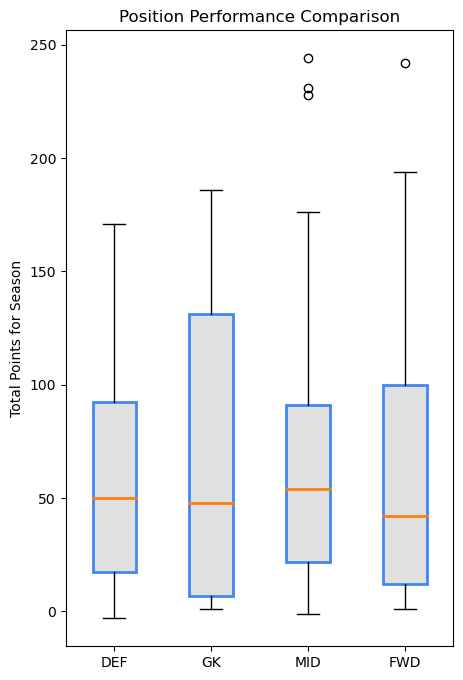

<Figure size 640x480 with 0 Axes>

In [20]:
plt.style.use('default')
plt.figure(figsize=(5,8), dpi=100)
DEF = ptp.loc[ptp.position == "DEF"]['total_points']
GK = ptp.loc[ptp.position == "GK"]['total_points']
MID = ptp.loc[ptp.position == "MID"]['total_points']
FWD = ptp.loc[ptp.position == "FWD"]['total_points']
bp = plt.boxplot([DEF, GK, MID, FWD], labels=['DEF','GK','MID', 'FWD'], patch_artist=True, medianprops={'linewidth': 2})

plt.title('Position Performance Comparison')
plt.ylabel('Total Points for Season')

for box in bp['boxes']:
    box.set(color='#4286f4', linewidth=2)
    box.set(facecolor = '#e0e0e0' )
plt.show()
plt.savefig('position_peformance.png')

We see from the aboce that Midfielders have the highest median but exluding outliers they don't have the highest maximum. Forwards have the highest maximum but the lowest median, suggesting forwards must be chosen wisely to score high points. Goalkeepers appear to have a large spread of scores with 50% of data being spread over an 100 point difference. We can clearly see that certain midfielders and one forward are the outliers, out performing other players by a country mile. These are players we would wish to target, regardless of what formation we choose each week.

__Next let's analyse formation performance even further by creating a cumulative distribution for each position__

Text(0.5, 1.0, 'Cumulative Distribution for Points achieved by Position')

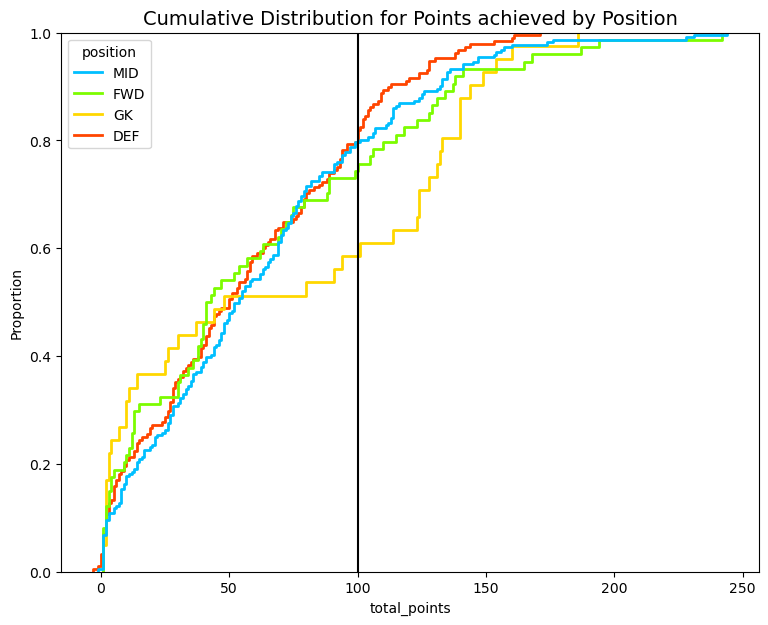

In [21]:
plt.style.use('default')
colors = ["deepskyblue", "lawngreen", "gold", "orangered"]
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(9, 7)) 
ax = sns.ecdfplot(x = 'total_points', data=ptp, hue ='position',  lw =2, legend=True) 
ax.axvline(100, c='black')
plt.title('Cumulative Distribution for Points achieved by Position', fontsize = 14)

We see from the distribution above that almost 60% of goalkeepers lie below the 100 point mark, meaning over 40% of goalkeepers score more than 100 points. This is significant as we see that only about 25% of forwards and 20% of midfielders and defenders score more than 100 points. Midfielders and Forwards have the longest tail, thus showing that the top players in these positions can score some very high values. We also see that almost 40% of goalkeepers score less than 25 points. This tells us that we must pick a decent enough keeper as the likelihood of return is high for the top 40%.

__Next let's analyse the 'elite' players__ for the season by their position. Elite players can be defined as the top 20 points scoring players for the entire season. We want to see if a certain position contains the lions share of these players

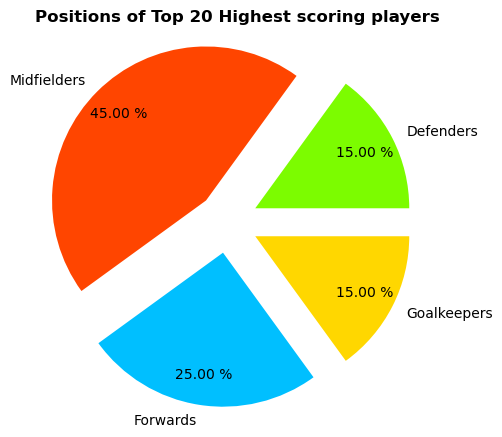

In [22]:
top20 = ptp.head(20)
plt.figure(figsize=(7,5), dpi=100)
DEF = top20.loc[top20.position == 'DEF'].count()[0]
MID = top20.loc[top20.position == 'MID'].count()[0]
FWD = top20.loc[top20.position == 'FWD'].count()[0]
GK = top20.loc[top20.position == 'GK'].count()[0]
positions = [DEF,MID, FWD, GK]
label = ['Defenders', 'Midfielders', 'Forwards', 'Goalkeepers']
explode = (.2,.2,.2,.2)
colours = ['lawngreen','orangered','deepskyblue','gold']
plt.title('Positions of Top 20 Highest scoring players', fontsize=12, fontweight="bold", loc='left')
plt.pie(positions, labels=label, explode=explode, pctdistance=0.8,autopct='%.2f %%', colors=colours)
plt.savefig('top20_positions.png', dpi=100)
plt.show()

Our cumulative distribution and our box plot had shown us that midfielders and forwards seemed to contain some of the highest point scoring players and this is confirmed from the pie chart above. We see that midfielders account for 45% of the top 20 players and forwards account for 25%. This tell us that we should generally go for a formation that maximises midfielders especially and also forwards. Defenders look like they should be kept to a minimum, i.e. three at the back, however let's analyse this further to see if this is the correct approach.

## Next let's analyse the average points for each position across each game week

Let's begin by creating a data frame which groups the total points of each position by game week.

In [23]:
gw1 = gws
gw1 = gw1[gw1['minutes'] > 0]
gw1 = gw1.drop('gw', axis=1)
gw1 = gw1.reset_index()
gw1 = gw1.groupby(['gw', 'position'])['total_points'].sum()
gw1 = gw1.to_frame()
gw1.head(8)

total_points
gw position              
1  DEF              257.0
   FWD               88.0
   GK                59.0
   MID              304.0
2  DEF              173.0
   FWD              193.0
   GK                60.0
   MID              380.0

Next let's create a data frame which groups the number of players in each position by game week

In [24]:
temp = gws
temp = temp[temp['minutes'] > 0]
temp = temp.drop('gw', axis=1)
gw2 = temp.groupby(['gw'])['position'].value_counts()
gw2 = gw2.to_frame()
gw2.rename(columns = {'position':'num_players'}, inplace = True)
gw2.head(8)

num_players
gw position             
1  MID               106
   DEF                70
   FWD                30
   GK                 16
2  MID               126
   DEF                90
   FWD                39
   GK                 20

Following this, let's merge our two data frames and add a new column which gets the average points of a particular position by game week

In [25]:
pgw = pd.merge(gw1, gw2, on=['gw','position'], how='left').reset_index()
pgw['avg_pos_points'] = (pgw['total_points']/pgw['num_players']) 
pgw = pgw.round(2)
pgw.head(8)

,gw,position,total_points,num_players,avg_pos_points
0,1,DEF,257.0,70,3.67
1,1,FWD,88.0,30,2.93
2,1,GK,59.0,16,3.69
3,1,MID,304.0,106,2.87
4,2,DEF,173.0,90,1.92
5,2,FWD,193.0,39,4.95
6,2,GK,60.0,20,3.00
7,2,MID,380.0,126,3.02


Let's have a look at how each position scores points across all players for each week in our season

Text(0.5, 1.0, 'Average Players Mean Position Points Each Game week')

<Figure size 1800x1500 with 0 Axes>

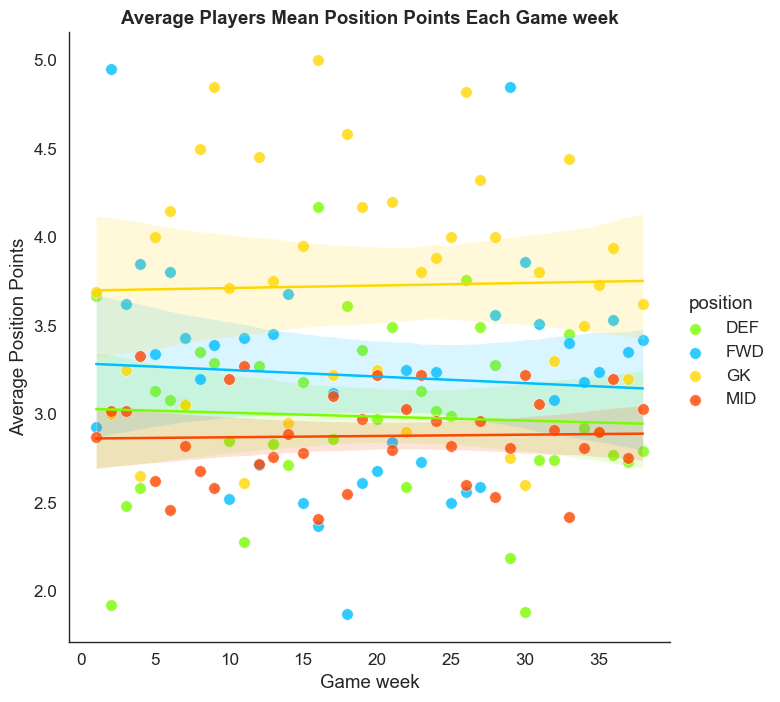

In [26]:
sns.set_style('white')
sns.set_context('paper', font_scale=1.4)
plt.figure(figsize=(18,15))
colors = ["lawngreen", "deepskyblue", "gold", "orangered"]
sns.set_palette(sns.color_palette(colors))
sns.lmplot(x='gw', y='avg_pos_points', hue='position', data=pgw, height=7,   
          scatter_kws={'s': 70, 'linewidth': 0.5, 'edgecolor': 'w'})
plt.xlabel("Game week")
plt.ylabel("Average Position Points")
plt.title("Average Players Mean Position Points Each Game week", weight="bold")

We see from the above that goalkeepers actually have the highest points on average for the season. This shouldn't surprise us too much as we saw from our cumulative distribution earlier that 40% of keepers scored more than 100 points in the season. Despite having some of the highest point scoring players, midfielders actually score the lowest on average each game week. Forwards score the best out of the outfield positions suggesting that we should target more forwards. The problem with this graph, however, is that it's showing point averages for all players in the Premier League. We should really be focusing only on the top performing players for each position, as we are unlikely to be choosing under performing players. Let's start to analyse how each position fares against one another with regards to the top performing players in each position.

## Elite Player's Position Points Performance
Seeing as there are much more midfielders and defenders in the Premier League, let's analyse the top 20 players from each of these positions. For forwards and goalkeepers let's analyse the top 10 players. Let's also use our earlier data frame, __ptp__, which looked at __players total points__ for the season.

In [27]:
#Let's create filters to isolate the players from each of the four positions
filtd = ptp['position'] == 'DEF'
filtm = ptp['position'] == 'MID'
filtf = ptp['position'] == 'FWD'
filtg = ptp['position'] == 'GK'

top_defenders = ptp.loc[filtd].head(20)
top_midfielders = ptp.loc[filtm].head(20)
top_forwards = ptp.loc[filtf].head(10)
top_goalkeepers = ptp.loc[filtg].head(10)

# Now let's create lists containing the names of the top players from each of these positions and 
# insert all those names into one list of the top players across the positions
top_def = top_defenders['name'].to_list()
top_mid = top_midfielders['name'].to_list()
top_fwd = top_forwards['name'].to_list()
top_gk = top_goalkeepers['name'].to_list()
top_players = top_def + top_mid + top_fwd + top_gk

# Next let's create a new data frame for the top players in each position
gwtop = gws[gws['name'].isin(top_players)]
gwtop = gwtop[gwtop['minutes'] > 0]
gwtop.head()

,id,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
gw,,,,,,,,,,,,,,,,,,,,,
1,62,Lewis Dunk,DEF,Brighton,1.1,0.0,0.0,16.0,0.0,1.2,...,1.0,7.0,1.0,0.0,0.0,0.0,50.0,True,0.0,1
1,102,César Azpilicueta,DEF,Chelsea,3.9,0.0,0.0,3.0,0.0,0.5,...,1.0,2.0,1.0,0.0,0.0,0.0,60.0,False,0.0,1
1,120,Mason Mount,MID,Chelsea,3.4,0.0,0.0,9.0,0.0,28.6,...,1.0,9.0,2.0,0.0,0.0,0.0,70.0,False,0.0,1
1,123,Reece James,DEF,Chelsea,3.1,1.0,3.0,44.0,0.0,30.3,...,1.0,11.0,14.0,0.0,0.0,0.0,50.0,False,0.0,1
1,141,Wilfried Zaha,MID,Crystal Palace,2.4,0.0,0.0,18.0,1.0,1.4,...,1.0,21.0,8.0,0.0,0.0,0.0,70.0,True,0.0,1


Let's go through the same process for our new elite players, first creating a data frame which groups the total points of each position by game week.

In [28]:
gwtop1 = gwtop
gwtop1 = gwtop1.drop('gw', axis=1)
gwtop1 = gwtop1.reset_index()
gtp = gwtop1.groupby(['gw', 'position'])['total_points'].sum()
gtp = gtp.to_frame()
gtp.head(8)

total_points
gw position              
1  DEF               43.0
   FWD               43.0
   GK                14.0
   MID               49.0
2  DEF               64.0
   FWD               81.0
   GK                38.0
   MID              112.0

Next let's create a data frame which groups the number of top players in each position by game week

In [29]:
pptop = gwtop1.groupby(['gw'])['position'].value_counts()
gtp2 = pptop.to_frame()
gtp2.rename(columns = {'position':'num_players'}, inplace = True)
gtp2.head(8)

num_players
gw position             
1  MID                10
   DEF                 9
   FWD                 8
   GK                  6
2  MID                16
   DEF                14
   FWD                10
   GK                  9

Finally, let's merge our two data frames and add a new column which gets the average points of a particular position by game week

In [30]:
pgwtop = pd.merge(gtp, gtp2, on=['gw','position'], how='left').reset_index()
pgwtop['avg_pos_points'] = (pgwtop['total_points']/pgwtop['num_players']) 
pgwtop = pgwtop.round(2)
pgwtop

,gw,position,total_points,num_players,avg_pos_points
0,1,DEF,43.0,9,4.78
1,1,FWD,43.0,8,5.38
2,1,GK,14.0,6,2.33
3,1,MID,49.0,10,4.90
4,2,DEF,64.0,14,4.57
...,...,...,...,...,...
147,37,MID,73.0,18,4.06
148,38,DEF,59.0,16,3.69
149,38,FWD,42.0,8,5.25
150,38,GK,39.0,8,4.88


Let's start by using a regression plot to analyse each of the position performances for top players across the full season

<Figure size 1000x800 with 0 Axes>

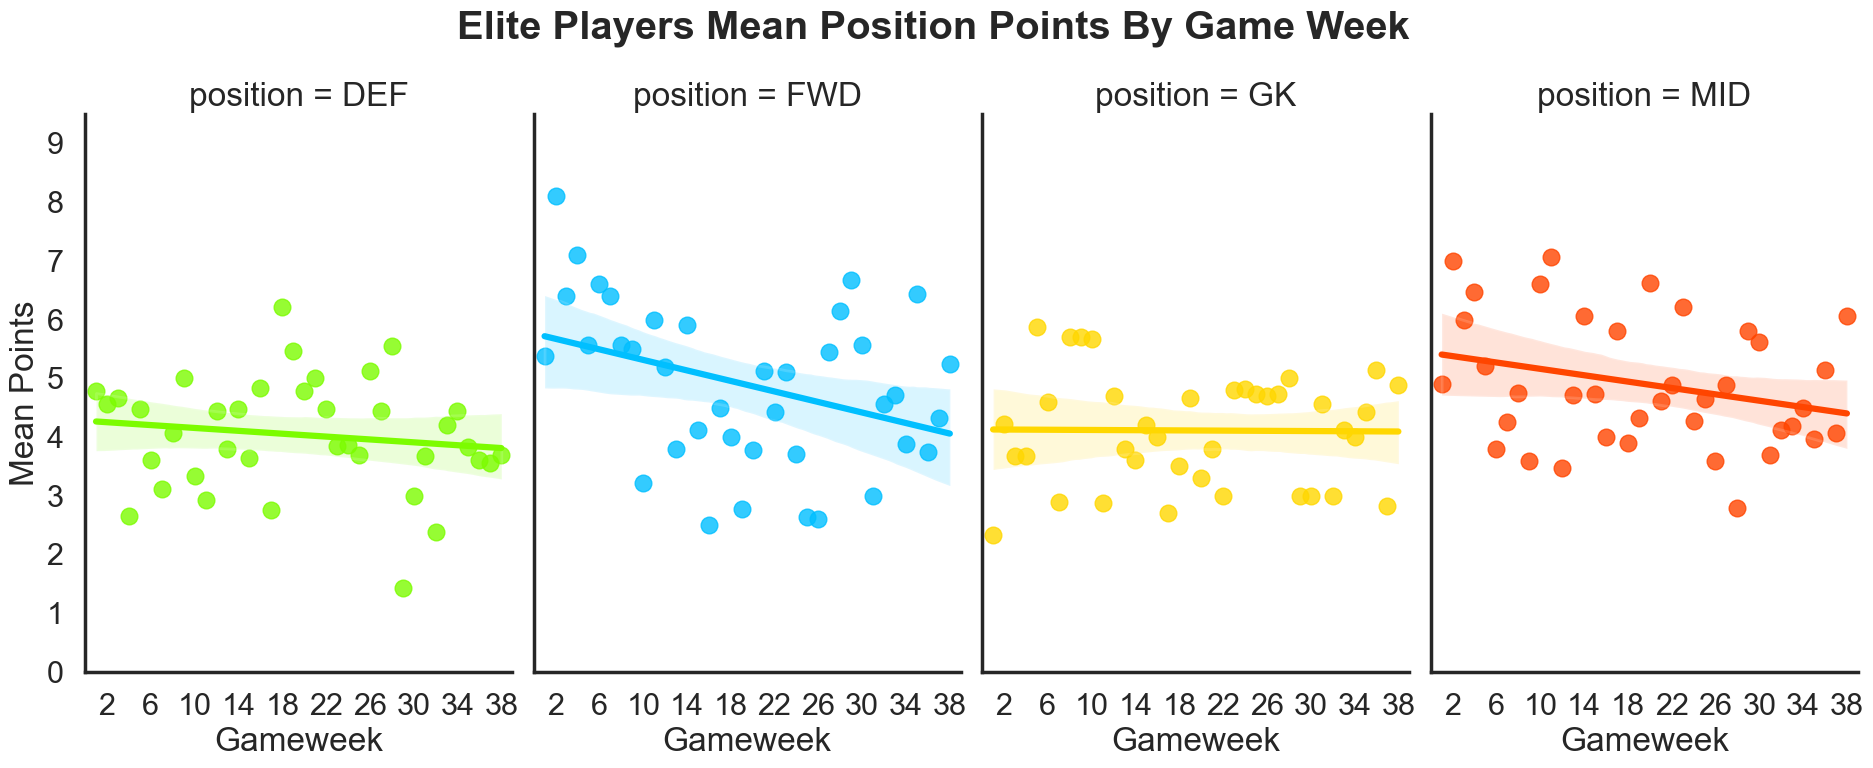

In [31]:
sns.set_context('poster')
plt.figure(figsize=(10,8))
sns.set_style('white')
position_colors = ["lawngreen", "deepskyblue", "gold", "orangered"]
sns.set_palette(sns.color_palette(colors))
g = sns.lmplot(x='gw', y='avg_pos_points', data=pgwtop, col='position', hue='position',
          height=8, aspect=0.6)

g = (g.set_axis_labels("Gameweek", "Mean Points")
      .set(xlim=(0, 39), ylim=(0, 9.5),
           xticks=[2, 6, 10, 14, 18, 22, 26, 30, 34, 38], yticks=[0, 1, 2, 3, 4, 5, 6, 7 , 8, 9])
      .fig.subplots_adjust(wspace=.05))
plt.subplots_adjust(top=0.85)
plt.suptitle('Elite Players Mean Position Points By Game Week', weight='bold')
plt.savefig('top_players_mean_points', dpi=100)

What we can take from these graphs is that we should definitely target formations
which are midfielder/forward heavy, especially early in the season. We see that forwards suffer a huge drop off as the season progresses but even at their lowest point, they score as high as defenders. Midfielders suffer less of a drop off at the end of the season so it looks like we should start with a 3-4-3 and switch to a 5 midfield formation by the end of the season. However let's look into this further to see if the rest of our analysis tells a different story.

# Formation Points Performances for the Season

We're going to use the average player points by position, which we previously calculated, to produce a new data frame containing the corresponding formation performances. This is basically a way to see if we were to choose a formation at random each game week, with no prior knowledge of player's ability, which formation on average would perform best points wise

The formations we can have require 1 goalkeeper, 3 defenders, 2 midfielders and at least 1 forward are selected at all times. There are only seven valid formations which include - __3-5-2, 3-4-3, 4-3-3, 4-4-2, 4-5-1, 5-2-3, 5-3-2__

__3-5-2__ = 1 * GK avg_pos_points + 3 * DEF avg_pos_points + 5 * MID avg_pos_points + 2 * FWD avg_pos_points

__3-4-3__ = 1 * GK avg_pos_points + 3 * DEF avg_pos_points + 4 * MID avg_pos_points + 3 * FWD avg_pos_points

__4-3-3__ = 1 * GK avg_pos_points + 4 * DEF avg_pos_points + 3 * MID avg_pos_points + 3 * FWD avg_pos_points

__4-4-2__ = 1 * GK avg_pos_points + 4 * DEF avg_pos_points + 4 * MID avg_pos_points + 2 * FWD avg_pos_points

__4-5-1__ = 1 * GK avg_pos_points + 4 * DEF avg_pos_points + 5 * MID avg_pos_points + 1 * FWD avg_pos_points

__5-2-3__ = 1 * GK avg_pos_points + 5 * DEF avg_pos_points + 2*MID avg_pos_points + 3 * FWD avg_pos_points

__5-3-2__ = 1 * GK avg_pos_points + 5 * DEF avg_pos_points + 3 * MID avg_pos_points + 2 * FWD avg_pos_points

In [32]:
# First we create a list containing formation names and dictionary with formation colours
fnames = ["3-5-2", "3-4-3", "4-3-3", "4-4-2", "4-5-1", "5-2-3", "5-3-2"]
formation_colours = {"3-5-2": "red", "3-4-3": "royalblue", "4-3-3": "green", "4-4-2": "cyan", "4-5-1": "purple", "5-2-3":"brown", "5-3-2": "yellow"}

Let's create a data frame containing positions as index, game weeks as columns and let's insert the average points as the values

In [33]:
pos_gw = pd.DataFrame()
for name, group in pgw.groupby("gw"):
    if pos_gw.empty:
        pos_gw = group.set_index("position")[["avg_pos_points"]].rename(columns={"avg_pos_points":str(name)})
    else:
        pos_gw = pos_gw.join(group.set_index("position")[["avg_pos_points"]].rename(columns={"avg_pos_points":str(name)}))

pos_gw.head()

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
position,,,,,,,,,,,,,,,,,,,,,
DEF,3.67,1.92,2.48,2.58,3.13,3.08,3.06,3.35,3.29,2.85,...,2.19,1.88,2.74,2.74,3.45,2.92,2.90,2.77,2.73,2.79
FWD,2.93,4.95,3.62,3.85,3.34,3.80,3.43,3.20,3.39,2.52,...,4.85,3.86,3.51,3.08,3.40,3.18,3.24,3.53,3.35,3.42
GK,3.69,3.00,3.25,2.65,4.00,4.15,3.05,4.50,4.85,3.71,...,2.75,2.60,3.80,3.30,4.44,3.50,3.73,3.94,3.20,3.62
MID,2.87,3.02,3.02,3.33,2.62,2.46,2.82,2.68,2.58,3.20,...,2.81,3.22,3.06,2.91,2.42,2.81,2.90,3.20,2.75,3.03


Next let's use this data frame to create a corresponding formation performance data frame across our season. Note that every formation contains one keeper, at least three defenders, at least two midfielders and at least one forward.

In [34]:
formation_df = pd.DataFrame(columns=pos_gw.columns, index = ["3-5-2", "3-4-3", "4-3-3", "4-4-2", "4-5-1", "5-2-3", "5-3-2"])
gg = pos_gw.reset_index()
filtg = gg['position'] == 'GK'
filtd = gg['position'] == 'DEF'
filtm = gg['position'] == 'MID'
filtf = gg['position'] == 'FWD'
for name in pos_gw.columns:
    formation_df.loc['3-5-2'][name] = (1 * (gg[filtg][name].max())) + (3*(gg[filtd][name].max())) + (5*(gg[filtm][name].max())) + (2*(gg[filtf][name].max()))
    formation_df.loc['3-4-3'][name] = (1 * (gg[filtg][name].max())) + (3*(gg[filtd][name].max())) + (4*(gg[filtm][name].max())) + (3*(gg[filtf][name].max()))
    formation_df.loc['4-3-3'][name] = (1 * (gg[filtg][name].max())) + (4*(gg[filtd][name].max())) + (3*(gg[filtm][name].max())) + (3*(gg[filtf][name].max()))
    formation_df.loc['4-4-2'][name] = (1 * (gg[filtg][name].max())) + (4*(gg[filtd][name].max())) + (4*(gg[filtm][name].max())) + (2*(gg[filtf][name].max()))
    formation_df.loc['4-5-1'][name] = (1 * (gg[filtg][name].max())) + (4*(gg[filtd][name].max())) + (5*(gg[filtm][name].max())) + (1*(gg[filtf][name].max()))
    formation_df.loc['5-2-3'][name] = (1 * (gg[filtg][name].max())) + (5*(gg[filtd][name].max())) + (2*(gg[filtm][name].max())) + (3*(gg[filtf][name].max()))
    formation_df.loc['5-3-2'][name] = (1 * (gg[filtg][name].max())) + (5*(gg[filtd][name].max())) + (3*(gg[filtm][name].max())) + (2*(gg[filtf][name].max()))
formation_df

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
3-5-2,34.91,33.76,33.03,34.74,33.17,33.29,33.19,34.35,34.4,33.3,...,33.07,32.06,34.34,32.23,33.69,32.67,33.41,35.31,31.84,33.98
3-4-3,34.97,35.69,33.63,35.26,33.89,34.63,33.8,34.87,35.21,32.62,...,35.11,32.7,34.79,32.4,34.67,33.04,33.75,35.64,32.44,34.37
4-3-3,35.77,34.59,33.09,34.51,34.4,35.25,34.04,35.54,35.92,32.27,...,34.49,31.36,34.47,32.23,35.7,33.15,33.75,35.21,32.42,34.13
4-4-2,35.71,32.66,32.49,33.99,33.68,33.91,33.43,35.02,35.11,32.95,...,32.45,30.72,34.02,32.06,34.72,32.78,33.41,34.88,31.82,33.74
4-5-1,35.65,30.73,31.89,33.47,32.96,32.57,32.82,34.5,34.3,33.63,...,30.41,30.08,33.57,31.89,33.74,32.41,33.07,34.55,31.22,33.35
5-2-3,36.57,33.49,32.55,33.76,34.91,35.87,34.28,36.21,36.63,31.92,...,33.87,30.02,34.15,32.06,36.73,33.26,33.75,34.78,32.4,33.89
5-3-2,36.51,31.56,31.95,33.24,34.19,34.53,33.67,35.69,35.82,32.6,...,31.83,29.38,33.7,31.89,35.75,32.89,33.41,34.45,31.8,33.5


Let's begin by simply analysing formation points across the season using a line plot which has markers for each game week. 

Text(0.5, 1.0, 'Average Players Mean Formation Point Performance')

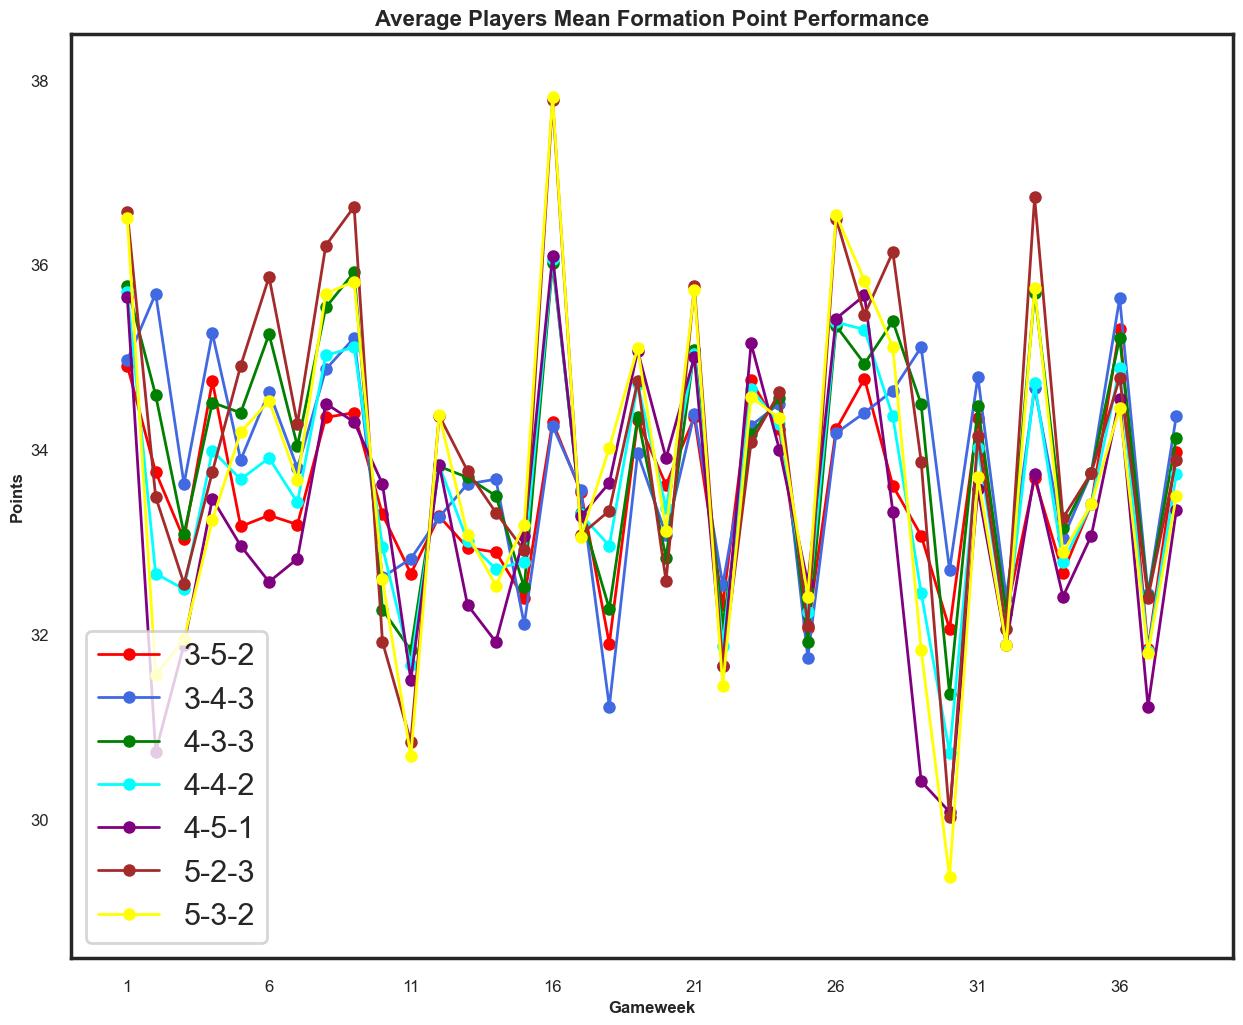

In [35]:
fig, ax = plt.subplots(figsize=(15,12))

fre = formation_df.T
fre.plot(ax=ax,marker='o', markersize=8, linewidth = 2, color=['red', 'royalblue','green', 'cyan', 'purple', 'brown', 'yellow'])

ax.set_ylabel("Points", weight='bold', fontsize=12)
ax.set_xlabel("Gameweek", weight='bold', fontsize=12)
ax.set_xlim(-2, 39)
ax.set_ylim(28.5, 38.5)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title('Average Players Mean Formation Point Performance', fontsize=16, weight='bold')

We see that the 5 at the back formations appear to be perfoming very well. This doesn;t surprise us as we're looking at all players here so defenders are actually scoring higher than other positions. Next let's look at the actual amount of points each formation achieved in the entire season

Let's begin by creating a data frame which is easier to analyse

In [36]:
formation_df.index.name = 'formation'
formation_df = formation_df.reset_index()
fdf = formation_df.melt(id_vars='formation')
fdf = fdf.rename(columns={'variable': 'gameweek', 'value': 'points'})
fdf["points"] = fdf["points"].astype(float)
fdf.head(8)

,formation,gameweek,points
0,3-5-2,1,34.91
1,3-4-3,1,34.97
2,4-3-3,1,35.77
3,4-4-2,1,35.71
4,4-5-1,1,35.65
5,5-2-3,1,36.57
6,5-3-2,1,36.51
7,3-5-2,2,33.76


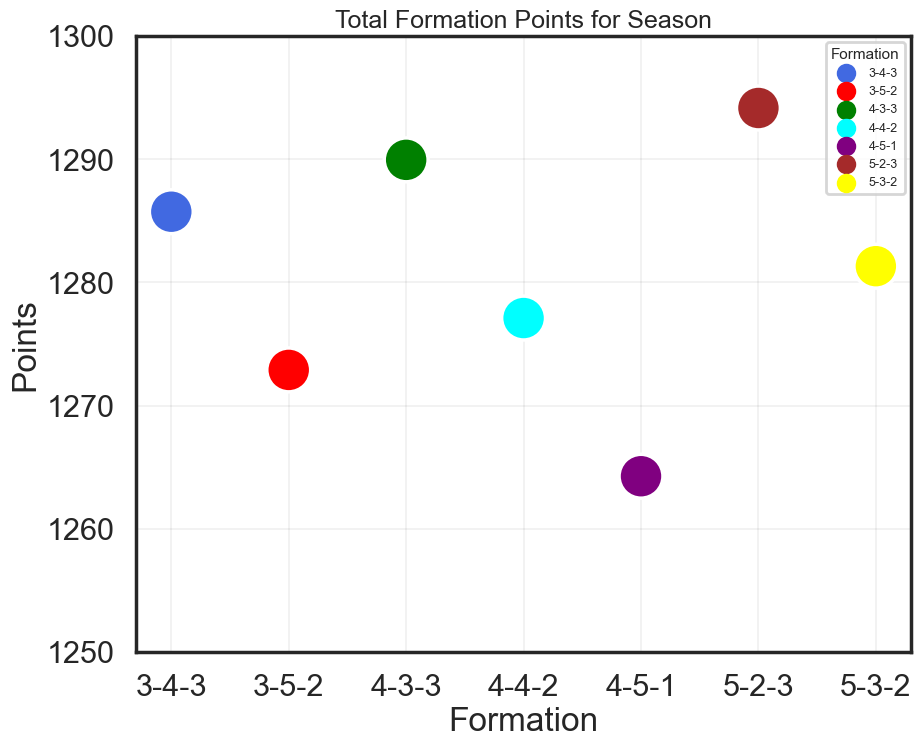

In [37]:
sumf = fdf.groupby('formation').sum()
sumf.reset_index(inplace = True)
plt.figure(figsize=(10,8))
plt.title("Total Formation Points for Season", fontsize=18)
ax = sns.scatterplot(x="formation", y="points", palette=formation_colours, data=sumf, s=1000, hue='formation')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.set_ylim(1250, 1300)
plt.xlabel('Formation')
plt.ylabel('Points')
plt.legend(title='Formation', fontsize='9', title_fontsize='11')

We see that although 5-2-3 comes out on top in terms of total points for all players, formations like 4-3-3 and 3-4-3 are very close in terms of points. For average squads, it appears that the more forwards you have, the better you'll do.

#### Next let's analyse the spread of points for each formation across the season

Text(0, 0.5, 'Points')

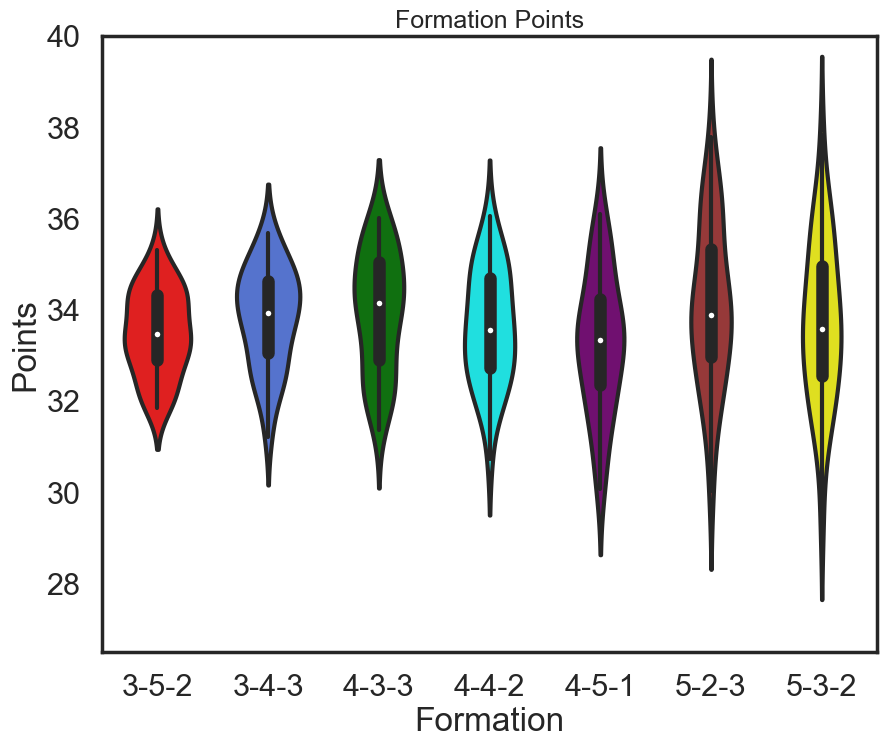

In [38]:
plt.figure(figsize=(10,8))
plt.title("Formation Points", fontsize=18)
ax = sns.violinplot(x="formation", y="points", width=0.6, palette=formation_colours, data=fdf)
ax.set_ylim(26.5, 40)
plt.xlabel('Formation')
plt.ylabel('Points')

We see that 3-5-2 and 3-4-3 don't generate some of the largest values, but are much more consistent in terms of points scored. 5 at the back formations are like a throw of the dice for average players. They can either achieve very high points or very low points on a given game week. 4-3-3 also looks consistent here although its highest values aren;t anything like the 5 at the back formation

### Analysing Formation 'Wins' for Average Players Across The Season
A win can be defined as the formation which accrues the largest sum of points in a particular game week. The formation with the most wins is the formation which scored highest the most times over the season

In [39]:
formadf = pd.DataFrame()
for name, group in fdf.groupby("formation"):
    if formadf.empty:
        formadf = group.set_index("gameweek")[["points"]].rename(columns={"points":str(name)})
    else:
        formadf = formadf.join(group.set_index("gameweek")[["points"]].rename(columns={"points":str(name)}))
windf = formadf.idxmax(axis="columns").value_counts()
b = pd.Series([0, 0, 0], index=['4-3-3', '4-4-2', '3-5-2'])
windf = windf.add(b, fill_value=0)
windf.sort_values(ascending = False, inplace=True)
windf

3-4-3    15.0
5-2-3    12.0
5-3-2     7.0
4-5-1     4.0
3-5-2     0.0
4-3-3     0.0
4-4-2     0.0
dtype: float64

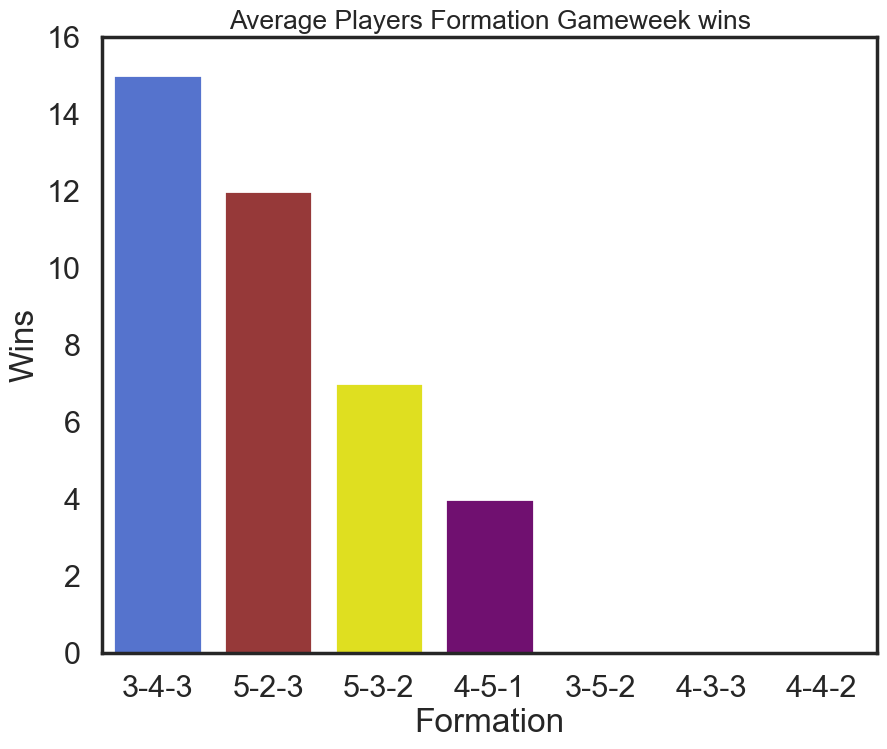

In [53]:
plt.figure(figsize=(10,8))
plt.title("Average Players Formation Gameweek wins", fontsize=19)
ax = sns.barplot(x=windf.index, y=windf, palette=formation_colours)
ax.set_ylim(0, 16)
plt.xlabel('Formation')
plt.ylabel('Wins')
plt.savefig('average_player_gw_wins.png')

We see that 3-4-3 actually generates the most wins over the entire season - likely due to its points consistency. 5-2-3 also registers some wins and should also be considered as it achieved the highest points tally for the season. 

## Next let's look at Formation Performance For Elite Players

In [41]:
pos_gwtop = pd.DataFrame()
for name, group in pgwtop.groupby("gw"):
    if pos_gwtop.empty:
        pos_gwtop = group.set_index("position")[["avg_pos_points"]].rename(columns={"avg_pos_points":str(name)})
    else:
        pos_gwtop = pos_gwtop.join(group.set_index("position")[["avg_pos_points"]].rename(columns={"avg_pos_points":str(name)}))

pos_gwtop

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
position,,,,,,,,,,,,,,,,,,,,,
DEF,4.78,4.57,4.67,2.65,4.47,3.61,3.12,4.06,5.00,3.33,...,1.43,3.00,3.68,2.38,4.20,4.45,3.83,3.60,3.56,3.69
FWD,5.38,8.10,6.40,7.10,5.56,6.60,6.40,5.56,5.50,3.22,...,6.67,5.56,3.00,4.56,4.71,3.88,6.43,3.75,4.33,5.25
GK,2.33,4.22,3.67,3.67,5.88,4.60,2.90,5.70,5.70,5.67,...,3.00,3.00,4.56,3.00,4.12,4.00,4.42,5.14,2.83,4.88
MID,4.90,7.00,6.00,6.47,5.21,3.80,4.26,4.75,3.59,6.61,...,5.80,5.61,3.69,4.12,4.18,4.50,3.96,5.14,4.06,6.06


In [42]:
formation_dftop = pd.DataFrame(columns=pos_gwtop.columns, index = ["3-5-2", "3-4-3", "4-3-3", "4-4-2", "4-5-1", "5-2-3", "5-3-2"])
ggtop = pos_gwtop.reset_index()
filtgtop = ggtop['position'] == 'GK'
filtdtop = ggtop['position'] == 'DEF'
filtmtop = ggtop['position'] == 'MID'
filtftop = ggtop['position'] == 'FWD'
for name in pos_gw.columns:
    formation_dftop.loc['3-5-2'][name] = (1 * (ggtop[filtgtop][name].max())) + (3*(ggtop[filtdtop][name].max())) + (5*(ggtop[filtmtop][name].max())) + (2*(ggtop[filtftop][name].max()))
    formation_dftop.loc['3-4-3'][name] = (1 * (ggtop[filtgtop][name].max())) + (3*(ggtop[filtdtop][name].max())) + (4*(ggtop[filtmtop][name].max())) + (3*(ggtop[filtftop][name].max()))
    formation_dftop.loc['4-3-3'][name] = (1 * (ggtop[filtgtop][name].max())) + (4*(ggtop[filtdtop][name].max())) + (3*(ggtop[filtmtop][name].max())) + (3*(ggtop[filtftop][name].max()))
    formation_dftop.loc['4-4-2'][name] = (1 * (ggtop[filtgtop][name].max())) + (4*(ggtop[filtdtop][name].max())) + (4*(ggtop[filtmtop][name].max())) + (2*(ggtop[filtftop][name].max()))
    formation_dftop.loc['4-5-1'][name] = (1 * (ggtop[filtgtop][name].max())) + (4*(ggtop[filtdtop][name].max())) + (5*(ggtop[filtmtop][name].max())) + (1*(ggtop[filtftop][name].max()))
    formation_dftop.loc['5-2-3'][name] = (1 * (ggtop[filtgtop][name].max())) + (5*(ggtop[filtdtop][name].max())) + (2*(ggtop[filtmtop][name].max())) + (3*(ggtop[filtftop][name].max()))
    formation_dftop.loc['5-3-2'][name] = (1 * (ggtop[filtgtop][name].max())) + (5*(ggtop[filtdtop][name].max())) + (3*(ggtop[filtmtop][name].max())) + (2*(ggtop[filtftop][name].max()))
formation_dftop

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
3-5-2,51.93,69.13,60.48,58.17,56.46,47.63,46.36,52.75,49.65,55.15,...,49.63,51.17,40.05,39.86,47.04,47.61,48.57,49.14,42.47,56.75
3-4-3,52.41,70.23,60.88,58.8,56.81,50.43,48.5,53.56,51.56,51.76,...,50.5,51.12,39.36,40.3,47.57,46.99,51.04,47.75,42.74,55.94
4-3-3,52.29,67.8,59.55,54.98,56.07,50.24,47.36,52.87,52.97,48.48,...,46.13,48.51,39.35,38.56,47.59,46.94,50.91,46.21,42.24,53.57
4-4-2,51.81,66.7,59.15,54.35,55.72,47.44,45.22,52.06,51.06,51.87,...,45.26,48.56,40.04,38.12,47.06,47.56,48.44,47.6,41.97,54.38
4-5-1,51.33,65.6,58.75,53.72,55.37,44.64,43.08,51.25,49.15,55.26,...,44.39,48.61,40.73,37.68,46.53,48.18,45.97,48.99,41.7,55.19
5-2-3,52.17,65.37,58.22,51.16,55.33,50.05,46.22,52.18,54.38,45.2,...,41.76,45.9,39.34,36.82,47.61,46.89,50.78,44.67,41.74,51.2
5-3-2,51.69,64.27,57.82,50.53,54.98,47.25,44.08,51.37,52.47,48.59,...,40.89,45.95,40.03,36.38,47.08,47.51,48.31,46.06,41.47,52.01


We can see already from above that our elite player's are scoring significantly more points than average players, especially at the start of the season

Text(0.5, 1.0, 'Elite Players Mean Formation Point Performance')

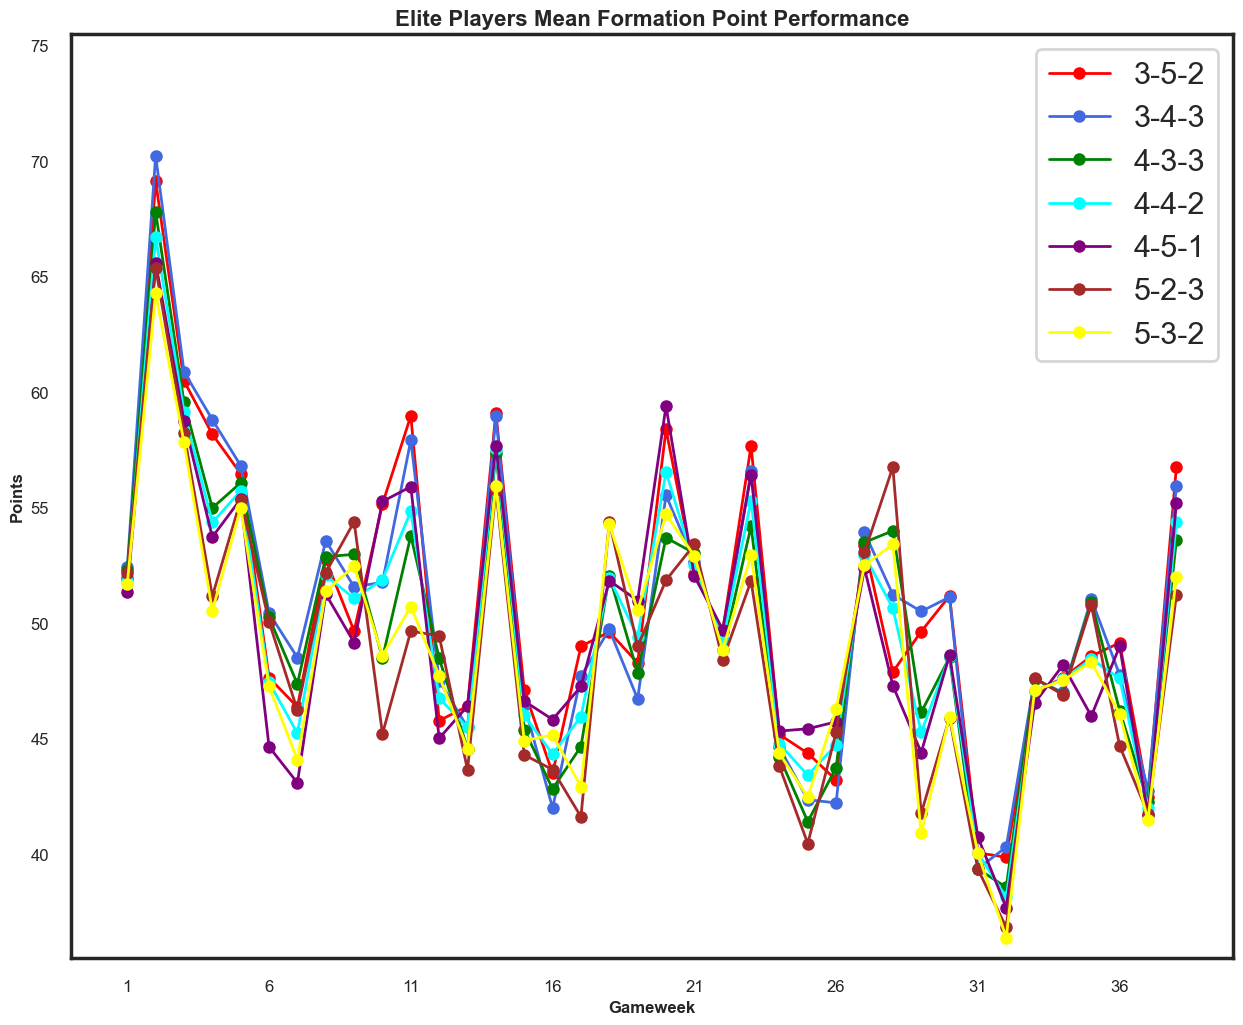

In [43]:
fig, ax = plt.subplots(figsize=(15,12))

fretop = formation_dftop.T
fretop.plot(ax=ax,marker='o', markersize=8, linewidth = 2, color=['red', 'royalblue','green', 'cyan', 'purple', 'brown', 'yellow'])

ax.set_ylabel("Points", weight='bold', fontsize=12)
ax.set_xlabel("Gameweek", weight='bold', fontsize=12)
ax.set_xlim(-2, 39)
ax.set_ylim(35.5, 75.5)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title('Elite Players Mean Formation Point Performance', fontsize=16, weight='bold')

3-5-2 and 3-4-3 appear to be the highest performing formations here. This doesn't surprise us as defenders score less for elite players and so formations without them should be targeted. 

In [44]:
formation_dftop.index.name = 'formation'
formation_dftop = formation_dftop.reset_index()
fdftop = formation_dftop.melt(id_vars='formation')
fdftop = fdftop.rename(columns={'variable': 'gameweek', 'value': 'points'})
fdftop["points"] = fdftop["points"].astype(float)
fdftop.head(8)

,formation,gameweek,points
0,3-5-2,1,51.93
1,3-4-3,1,52.41
2,4-3-3,1,52.29
3,4-4-2,1,51.81
4,4-5-1,1,51.33
5,5-2-3,1,52.17
6,5-3-2,1,51.69
7,3-5-2,2,69.13


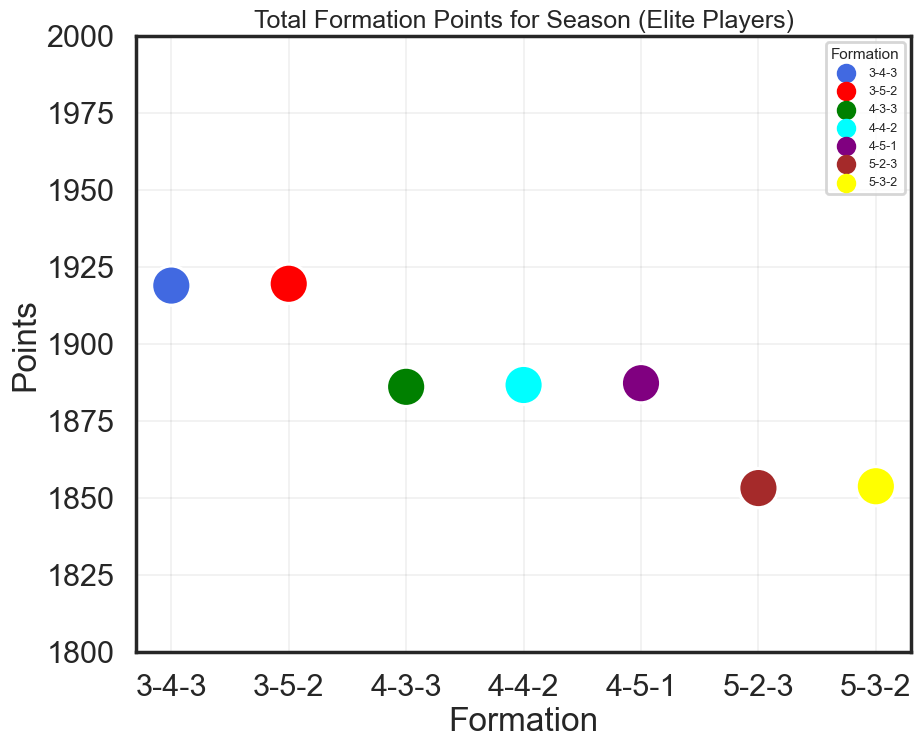

In [45]:
sumftop = fdftop.groupby('formation').sum()
sumftop.reset_index(inplace = True)
plt.figure(figsize=(10,8))
plt.title("Total Formation Points for Season (Elite Players)", fontsize=18)
ax = sns.scatterplot(x="formation", y="points", palette=formation_colours, data=sumftop, s=800, hue='formation')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.set_ylim(1800, 2000)
plt.xlabel('Formation')
plt.ylabel('Points')
plt.legend(title='Formation', fontsize='9', title_fontsize='11')

3-4-3 and 3-5-2 register the most points for the season whereas the 5 at the back formations register roughly 75 points less. 

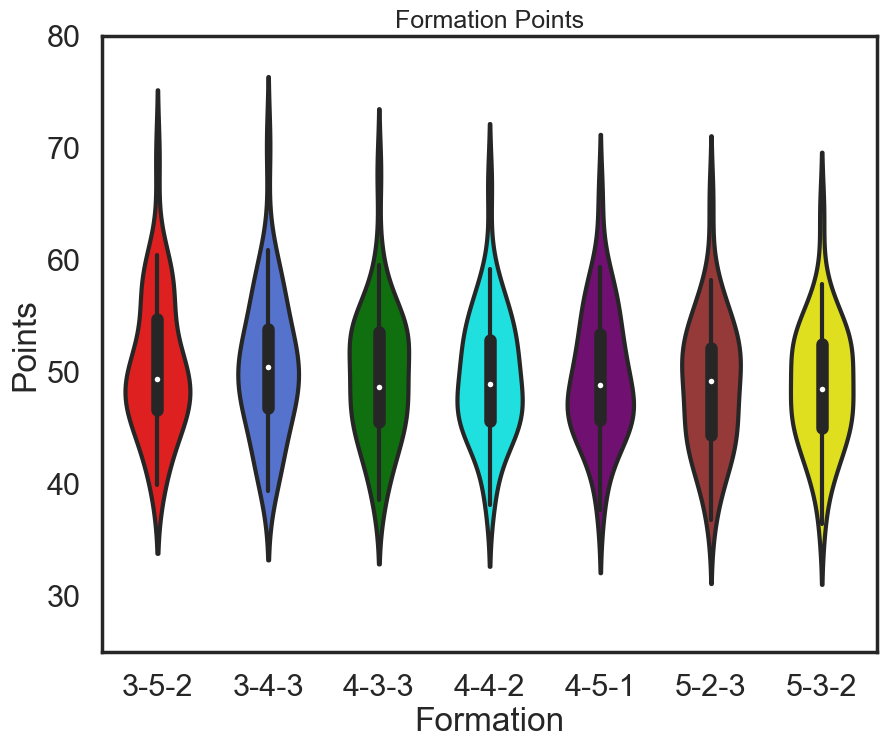

In [47]:
plt.figure(figsize=(10,8))
plt.title("Formation Points", fontsize=18)
ax = sns.violinplot(x="formation", y="points", width=0.6, palette=formation_colours, data=fdftop)
ax.set_ylim(25, 80)
plt.xlabel('Formation')
plt.ylabel('Points')
plt.savefig('top_players_formation_points.png')

We see from above that 3-4-3 and 3-5-2 look like the formations to go for, being most dense around the 60 point makr and having the highest outliers and the least very low scoring weeks. 3-4-3 also has the highest median. 5-3-2 and 5-2-3 look like formations to avoid, being more dense around the 40 point mark and having some of the lowest game week points totals for the season.

### Analysing Formation 'Wins' for Elite Players Across The Season
A win can be defined as the formation which accrues the largest sum of points in a particular game week. The formation with the most wins is the formation which scored highest the most times over the season

In [48]:
formadftop = pd.DataFrame()
for name, group in fdftop.groupby("formation"):
    if formadftop.empty:
        formadftop = group.set_index("gameweek")[["points"]].rename(columns={"points":str(name)})
    else:
        formadftop = formadftop.join(group.set_index("gameweek")[["points"]].rename(columns={"points":str(name)}))
windftop = formadftop.idxmax(axis="columns").value_counts()
btop = pd.Series([0, 0, 0], index=['4-3-3', '4-4-2', '3-5-2'])
windftop = windftop.add(btop, fill_value=0)
windftop.sort_values(ascending = False, inplace=True)
windftop = windftop.to_frame()
windftop.columns = ['wins']
windftop.index.name = "formation"
windftop = windftop.reset_index()
windftop.wins = windftop.wins.astype(int)
windftop

,formation,wins
0,3-4-3,13
1,3-5-2,9
2,4-5-1,9
3,5-2-3,6
4,5-3-2,1
5,4-3-3,0
6,4-4-2,0


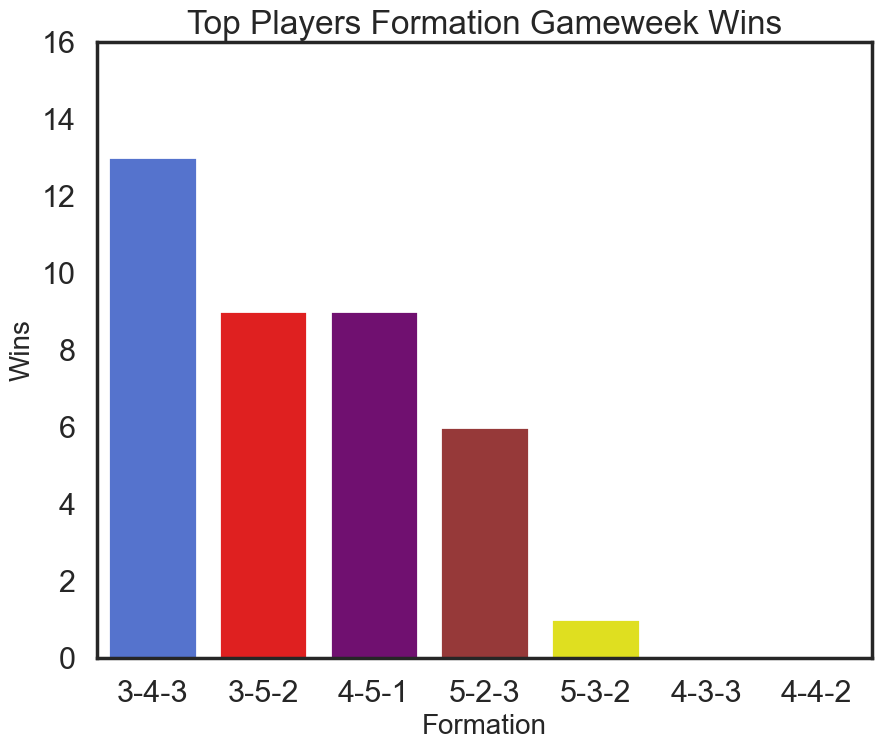

In [49]:
sns.set_context('poster')
plt.figure(figsize=(10,8))
sns.set_style('white')
plt.title("Top Players Formation Gameweek Wins", fontsize=24)
p1 = sns.barplot(x="formation", y="wins", palette=formation_colours, dodge=False, data = windftop)
p1.set_xlabel("Formation",fontsize=20)
p1.set_ylim(0, 16)
p1.set_ylabel("Wins",fontsize=20)
plt.savefig('top_player_gw_wins.png')

Once again we see that 3-4-3 comes out on top with wins for the season. 3-5-2 also registers a decent amount of wins as well as 4-5-1. Even though the 5 at the back formations look like ones to avoid, there were 7 game weeks in which they came out on top. 4-3-3 and 4-4-2 register zero wins once again and should definitely be avoided for the season.

## Elite Player's Position Points Performance based on Opponent Strength
First let's create a data frame that combines teams and gw data frames. This data frame contains details of player's performance each week including their team's strength and opposition team's strength

In [50]:
opponent_teams = teams
opponent_teams = opponent_teams.add_prefix('opponent_')
opponent_teams = opponent_teams.drop(['opponent_code','opponent_pulse_id', 'opponent_id'], axis=1)
opponent_teams = opponent_teams.reset_index()
opponent_teams.rename(columns = {'id':'opponent_team'}, inplace = True)
gws_teams = pd.merge(gws,opponent_teams, on=['opponent_team'], how='left')

team = teams
team = team.drop(['code','id'], axis=1)
team = team.reset_index()
team = team.drop(['id'], axis=1)
team.rename(columns = {'name':'team'}, inplace = True)
gws_teams = pd.merge(gws_teams,team, on=['team'], how='left')
gws_teams.head()

,id,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,...,opponent_strength_defence_away,short_name,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,David Luiz Moreira Marinho,DEF,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,ARS,4.0,1200.0,1250.0,1130.0,1150.0,1220.0,1210.0,1.0
1,4,Pierre-Emerick Aubameyang,MID,Arsenal,5.0,0.0,0.0,19.0,1.0,15.3,...,1060.0,ARS,4.0,1200.0,1250.0,1130.0,1150.0,1220.0,1210.0,1.0
2,5,Cédric Soares,DEF,Arsenal,3.1,0.0,0.0,0.0,0.0,0.0,...,1060.0,ARS,4.0,1200.0,1250.0,1130.0,1150.0,1220.0,1210.0,1.0
3,6,Alexandre Lacazette,FWD,Arsenal,4.0,0.0,1.0,29.0,0.0,12.7,...,1060.0,ARS,4.0,1200.0,1250.0,1130.0,1150.0,1220.0,1210.0,1.0
4,7,Shkodran Mustafi,DEF,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,ARS,4.0,1200.0,1250.0,1130.0,1150.0,1220.0,1210.0,1.0


Let's focus in on elite players for this analysis

In [51]:
gws_teams_top = gws_teams[gws_teams['name'].isin(top_players)]
gws_teams_top = gws_teams_top[gws_teams_top['minutes'] > 0]

teams_dist = gws_teams_top[['gw', 'name', 'position', 'strength','opponent_strength', 'total_points', 'minutes']]
teams_dist = teams_dist[teams_dist.minutes != 0]
teams_dist = teams_dist[teams_dist.total_points != 'NaN']
teams_dist = teams_dist.drop('minutes', axis=1)
teams_dist = teams_dist.dropna()

sumtd = teams_dist.groupby(['position', 'gw', 'strength', 'opponent_strength'])["total_points"].sum()
sumtd = sumtd.to_frame()

nump = teams_dist.groupby(['position', 'gw', 'strength'])['opponent_strength'].value_counts()
nump = nump.to_frame()
nump.rename(columns = {'opponent_strength':'num_players'}, inplace = True)

numsum = pd.merge(sumtd, nump, on=['gw','position', 'strength', 'opponent_strength']).reset_index()
numsum['avg_points'] = (numsum['total_points']/numsum['num_players']) 
numsum = numsum.round(2)
numsum

,gw,position,strength,opponent_strength,total_points,num_players,avg_points
0,1,DEF,3.0,4.0,22.0,4,5.50
1,1,DEF,4.0,2.0,1.0,1,1.00
2,1,DEF,4.0,3.0,20.0,4,5.00
3,2,DEF,3.0,2.0,45.0,6,7.50
4,2,DEF,3.0,3.0,1.0,1,1.00
...,...,...,...,...,...,...,...
937,38,MID,3.0,2.0,10.0,2,5.00
938,38,MID,3.0,4.0,19.0,4,4.75
939,38,MID,4.0,3.0,33.0,5,6.60
940,38,MID,4.0,4.0,5.0,1,5.00


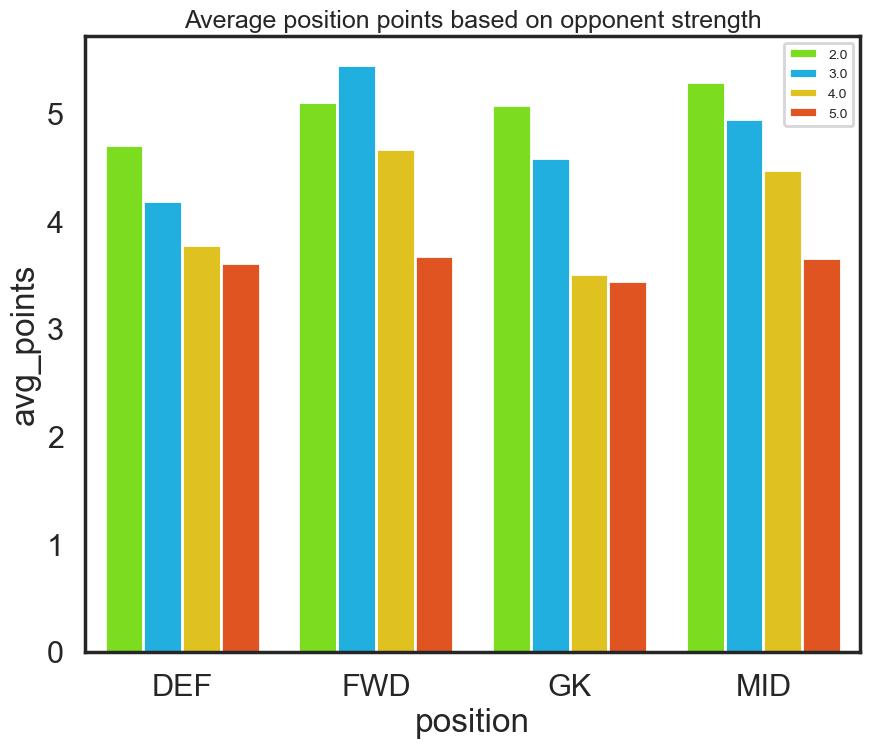

In [52]:
points_vs_strength = numsum.groupby(['position', 'opponent_strength'])['avg_points'].mean()
points_vs_strength=points_vs_strength.to_frame()
points_vs_strength = points_vs_strength.reset_index()
pvs = points_vs_strength.round(2)

plt.figure(figsize=(10,8))
plt.title("Average position points based on opponent strength", fontsize=18)
ax = sns.barplot(x="position", y="avg_points", data=pvs,  hue = 'opponent_strength')
plt.legend(fontsize='10')

We see from the above that all positions but forwards score highest over the season against opposition of strength 2. Forwards actually score highest against teams of strength 3. We should very rarely play keepers when they face a team of strength 4 or 5. Avoiding playing any players against Man City is a reasonable judgement call. Besides that we should play as many players facing strength 2 teams as possible, and also any forwards facing strength 2/3 teams. Once again we see that defenders should be minimised. Midfielders should be prioritised if against strength 2 teams. A 3-4-3 with players that have opponents of strength 2 and 3 looks like the ideal strategy in picking formation 